In [40]:
import pandas as pd
import numpy as np
import re
import os

from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

import torch as T

import acn
import importlib
importlib.reload(acn)
from IPython.display import clear_output
from collections import deque

import gymnasium as gym

In [41]:
env_id = "CartPole-v1"
env = gym.make(env_id)#,render_mode="human")

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("The Action Space is: ", a_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  4
The Action Space is:  2
Sample observation [-2.4072861e-02 -2.6328103e+38 -3.6934683e-01  1.7866300e+38]


In [53]:
N_STEPS = 5
avg_win_size = 50
epi_results = deque(maxlen=avg_win_size)
episodes = 100_000
GAMMA = 0.99
lr = 0.001
lyr1 = 64
lyr2 = 128

agent = acn.ActorCritic(s_size, a_size, lyr1 = lyr1, lyr2=lyr2,
                    gamma = GAMMA, lr = lr )

In [54]:
# model and log file names
log_file_name = os.path.join('.','artefacts',f'{env_id}_acn.csv')
model_file = os.path.join('.','models',f'{env_id}_acn.pth')

In [55]:
train = False

if train:
    # Delete old trainig log if exists
    if os.path.exists(log_file_name):
        os.remove(log_file_name)

    log_file = open(log_file_name, "w")
    log_file.write(f'episode,rewards\n')

    for epi in range(episodes):
        
        done = False
        s, _ = env.reset()
        actions, states, rewards = [], [], []
        epi_reward = 0
        t = 0

        while not done:
            s_t =  T.FloatTensor(np.expand_dims(s,0))
            probs , _ = agent.forward(s_t)
            a = T.multinomial(probs, 1).item()
            #log_prob = T.log(probs[0][a])
            
            s_, r, done, _, _ = env.step(a)
            epi_reward += r
            t+=1
            if t > 500:
                done = True
            actions.append(a)
            rewards.append(r)
            states.append(s)
        
            s = s_

            if done or t%N_STEPS == 0:
                agent.calc_loss(states, actions, rewards, done, s_)
                actions, states, rewards = [], [], []
        
        epi_results.append(epi_reward)
        log_file.write(f'{epi},{epi_reward:.2f}\n')
        if epi % 10 == 0:
            print(f"Episode {epi+1}/{episodes}, Reward: {epi_reward:.2f}, mean_rewards:{np.mean(epi_results):.2f}")
        if epi % 100 == 0:
            clear_output(wait=True)
        
        if np.mean(epi_results)>500:
            log_file.close()
            print('saving models')
            agent.save_model(model_file)
            break

Episode 2611/100000, Reward: 501.00, mean_rewards:347.96
Episode 2621/100000, Reward: 86.00, mean_rewards:347.38
Episode 2631/100000, Reward: 501.00, mean_rewards:386.82
Episode 2641/100000, Reward: 501.00, mean_rewards:427.56
Episode 2651/100000, Reward: 501.00, mean_rewards:468.38
Episode 2661/100000, Reward: 501.00, mean_rewards:472.38
Episode 2671/100000, Reward: 501.00, mean_rewards:491.68
saving models


In [52]:
log_file.close()

Text(0.5, 1.0, 'Rewards & Mean Rewards')

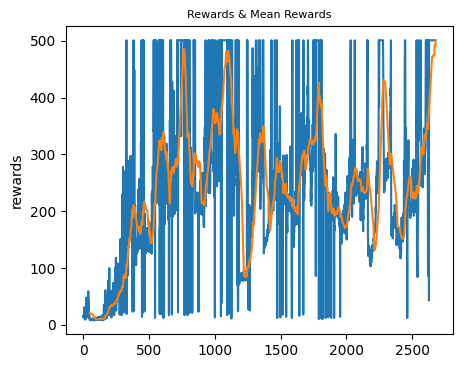

In [56]:
df = pd.read_csv(log_file_name)
df['mean_rewards'] = df['rewards'].rolling(avg_win_size).mean()

fig,ax=plt.subplots(1,1,sharex='col',sharey= False,figsize=(5,4))

sns.lineplot(df['rewards'], ax = ax)
sns.lineplot(df['mean_rewards'],ax = ax)
ax.set_title('Rewards & Mean Rewards',fontsize=8)

In [57]:
eval_agent = acn.ActorCritic(s_size, a_size, lyr1 = lyr1, lyr2=lyr2,
                    gamma = GAMMA)
eval_agent.load_model(model_file)

In [58]:
eval_env = gym.make(env_id,render_mode="human")

for epi in range(10):

    s,_ = eval_env.reset()
    term = False
    trunc = False
    score = 0

    while not any([term, trunc]):

        #obs = T.FloatTensor(np.expand_dims(s,0)).to(device)

        with T.no_grad():
            s_t =  T.FloatTensor(np.expand_dims(s,0))
            probs , _ = eval_agent.forward(s_t)
        a = T.multinomial(probs, 1).item()

        #p_vals = p_vals.detach().cpu().numpy()
        
        #a = np.argmax(p_vals)
        s, r, term ,trunc , _  = eval_env.step(a)
        
        score+=r
        
    print(f'{epi = } result {score:4.2f}')
eval_env.close()

epi = 0 result 500.00
epi = 1 result 500.00
epi = 2 result 500.00
epi = 3 result 500.00
epi = 4 result 500.00
epi = 5 result 500.00
epi = 6 result 500.00
epi = 7 result 500.00
epi = 8 result 500.00
epi = 9 result 500.00
